In [1]:
import psycopg2
from psycopg2.extensions import register_adapter, AsIs
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import collections
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.cluster import KMeans
import string
import wfdb

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
np.set_printoptions(suppress=True,precision=10)

In [2]:
def obtainMeasures(dbname="mimic",unlimit=False,centroid=None) :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    limit = "" if unlimit else " ORDER BY random() LIMIT 20000 "
    null = " AND centroid is null" if centroid is None else "AND centroid IS NOT NULL" if centroid =="notNull" else "" 
    paramCentroid = ",centroid " if centroid == "notNull" else ""
    select_stament = ("SELECT qt,ts,sr"+paramCentroid+" FROM rstq "
                      " WHERE qt > 0 AND qt<1000 "
                      " AND ts > 0 "
                      " AND sr IS NOT NULL "+null+" GROUP BY qt,ts,sr"+paramCentroid+limit)
    print(select_stament)
    cur.execute(select_stament)
    waves = []
    for row in cur :
        qt = row[0]
        ts = row[1]
        sr = row[2]
        if centroid  =="notNull" :
            waves.append([qt,ts,sr,row[3]])
        else :
            waves.append([qt,ts,sr])
    conn.close()
    print("number of distinct heartbeats:",len(waves))
    return waves

In [3]:
def printKmeans(kmeans) :
    labels, values = zip(*collections.Counter(kmeans.labels_).items())
    indexes = np.arange(len(labels))
    width = 0.5
    fig, ax = plt.subplots() 
    for i, v in enumerate(values):
        ax.text(i-0.1,v+1, str(v), color='blue', fontweight='bold')
    plt.bar(indexes, values, width)
    plt.title('Cantidad de Latidos por centroide')
    plt.ylabel('Cantidad de latidos')
    plt.xlabel('Centroides')
    numberToAlpha = dict(enumerate(string.ascii_lowercase, 0))    
    plt.xticks(indexes + width * 0.01, [numberToAlpha[label] for label in labels])
    plt.show()

In [4]:
def findElbow(X):
    # k means determine k
    distortions = []
    K = range(2,22,2)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        cluster_labels = kmeanModel.fit_predict(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
        print("K=",k,end=",")
    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.xticks(K)
    plt.show()
    for i in range(1,len(distortions)) :
        print(str(i*2)+":",distortions[i-1]-distortions[i],end=", ")

In [5]:
waves = obtainMeasures(centroid="all",unlimit=False)
X = np.array(waves)

SELECT qt,ts,sr FROM rstq  WHERE qt > 0 AND qt<1000  AND ts > 0  AND sr IS NOT NULL  GROUP BY qt,ts,sr ORDER BY random() LIMIT 20000 
number of distinct heartbeats: 20000


In [6]:
centroid=np.array([
 [80.6249206776,34.4072341942,18.0654919722]
,[27.5433134377,63.0542687151,20.1936270556]
,[37.8806590078,28.0581910623,58.6082070374]
,[153.5995271557,33.0196033362,14.637847245]
,[32.7841950261,141.3795344053,49.8454796185]
,[252.6050595323,32.6354966736,14.6705593467]
,[372.7386300819,30.7641087492,15.2788079803]
,[542.3333662583,29.6270248913,14.8596404583]
,[31.1998859099,77.3158014832,247.2476896749]
,[789.1761990768,28.8695564921,13.7471402769]
,[25.309598268,439.5821505894,107.6622564349]
,[28.524825784,99.4141986063,577.2391114982]])
kmeans = KMeans(n_clusters=12
                ,init=centroid,n_init=1
               ).fit(X)

In [7]:
centroid = kmeans.cluster_centers_
print(centroid)

[[  73.7941052632   33.6385263158   18.6877894737]
 [  25.695683112    62.2070683112   20.8849620493]
 [  37.2325399922   28.6453374951   62.4268435427]
 [ 141.2613890963   33.7266616878   14.9675130695]
 [  33.0105596621  137.3078141499   48.5         ]
 [ 233.6822488945   33.260897031    13.9538850284]
 [ 350.1952965235   31.591002045    14.6390593047]
 [ 510.0922131148   29.9139344262   15.4508196721]
 [  30.1633237822   77.11747851    247.0773638968]
 [ 768.46875        29.8214285714   14.6651785714]
 [  25.8502673797  423.3422459893   99.0802139037]
 [  28.5888888889  104.5333333333  593.9777777778]]


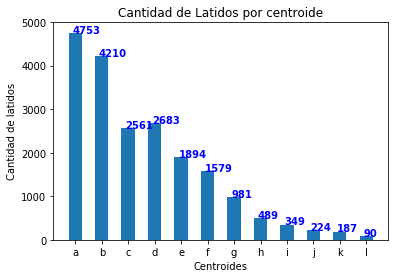

In [8]:
printKmeans(kmeans)

In [9]:
def updateQRST(wacentroid) :
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    select_stament = """
    UPDATE rstq AS t
    SET
        centroid = s.centroid
        FROM unnest(%s) s(qt integer,ts integer,sr integer,centroid unknown)
        WHERE t.qt = s.qt
        AND t.ts = s.ts
        AND t.sr = s.sr;
    """
#    print(cur.mogrify(select_stament, (wacentroid,)))
    cur.execute(select_stament, (wacentroid,))
    conn.commit()
    conn.close()

In [10]:
def fillEmptyCentroids(waves,kmeans, iterations=1280) :
    waves = waves[:iterations] if iterations<len(waves) else waves
    numberToAlpha = dict(enumerate(string.ascii_lowercase, 0))
    i = 1
    centro = []
    for wave in waves :
        try:
            centValue = numberToAlpha[kmeans.predict([[wave[0],wave[1],wave[2]]])[0]]
            centro.append((wave[0],wave[1],wave[2],str(centValue)))
        except:
            print("error in value")
        i=i+1
    if centro != [] :
        updateQRST(centro)

In [11]:
waves = obtainMeasures(unlimit=True,centroid=None)
for i in range(1,int(len(waves)/1000)):
    print("i",i)
    fillEmptyCentroids(waves,kmeans,iterations=2000*i)
    waves = obtainMeasures(unlimit=True,centroid=None)

SELECT qt,ts,sr FROM rstq  WHERE qt > 0 AND qt<1000  AND ts > 0  AND sr IS NOT NULL  AND centroid is null GROUP BY qt,ts,sr
number of distinct heartbeats: 0


In [12]:
fig_size = [12,9]
plt.rcParams["figure.figsize"] = fig_size
def centroidColor(clist) :
    color = {
        'a': "blue",
        'b': "red",
        'c': "green",
        'd': "magenta",
        'e': "cyan",
        'f': "fuchsia",
        'g': "limegreen", 
        'h': "pink",
        'i': "yellow",
        'j': "aqua",
        'k': "peru",
        'l': "lawngreen",
        'm': "maroon",
        'n': "navajowhite",
        'o': "orange",
        'p': "coral",
        None : "maroon"
    }
    return [color[x] for x in clist]

In [13]:
waves = obtainMeasures(unlimit=True,centroid="notNull")
qt = np.array([-item[0] for item in waves])
ts = np.array([item[1] for item in waves])
sr = np.array([item[2] for item in waves])
color = np.array([item[3] for item in waves])
qtc = np.array([-int(item[0]) for item in centroid])
tsc = np.array([item[1] for item in centroid])
src = np.array([item[2] for item in centroid])
color = centroidColor(color)

SELECT qt,ts,sr,centroid  FROM rstq  WHERE qt > 0 AND qt<1000  AND ts > 0  AND sr IS NOT NULL AND centroid IS NOT NULL GROUP BY qt,ts,sr,centroid 
number of distinct heartbeats: 481346


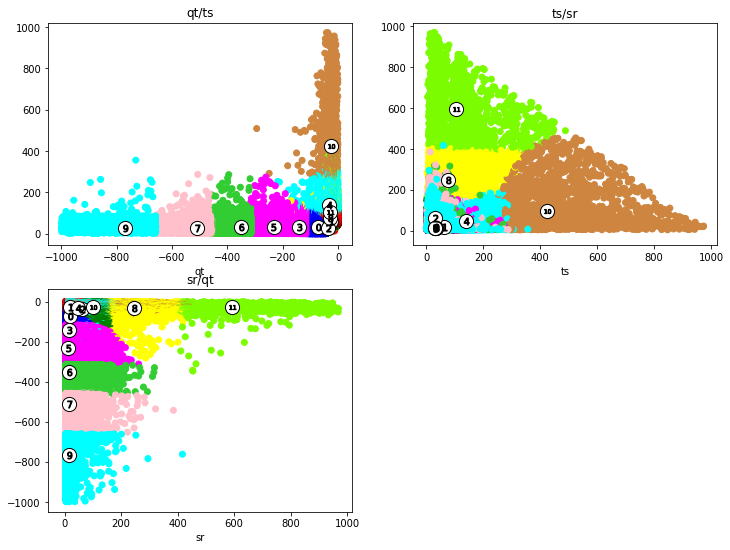

In [14]:
def scatter(posicion,title,xlabel,x,y,color,xc,yc,centroid,v0,v1):
    ax = fig.add_subplot(posicion)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.scatter(x,y, c=color)
    ax.scatter(xc,yc, marker='o',c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centroid):
        ax.scatter((-1 if v0==0 else 1)*c[v0], (-1 if v1==0 else 1)*c[v1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')


fig = plt.figure()
scatter(221,"qt/ts","qt",qt,ts,color,qtc,tsc,centroid,0,1)
scatter(222,"ts/sr","ts",ts,sr,color,tsc,src,centroid,1,2)
scatter(223,"sr/qt","sr",sr,qt,color,src,qtc,centroid,2,0)
plt.show()

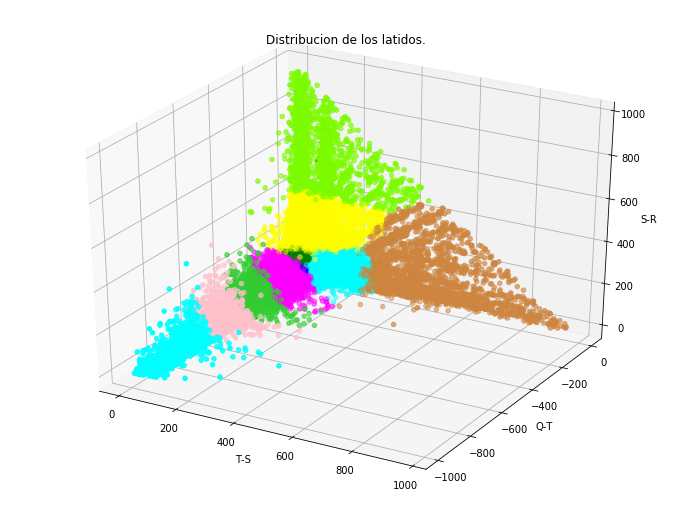

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ts,qt, sr, c=color)
ax.scatter(tsc,qtc, src, c='black',marker="^",s=160)
ax.set_title("Distribucion de los latidos.")
ax.set_xlabel("T-S")
ax.set_ylabel("Q-T")
ax.set_zlabel("S-R")
plt.show()

In [16]:
def findCentroid(centroid,window=0,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    qt = str(centroid[0])
    ts = str(centroid[1])
    sr = str(centroid[2])
    strWin = str(window)
    select_stament = ("SELECT rstq.record,r_s,q_s,a.rec_from,a.rec_to,wave,centroid "
                      " FROM rstq LEFT JOIN a ON a.record=rstq.record  "
                      " WHERE "
                      " (qt between floor("+qt+")-"+strWin+" and ceil("+qt+")+"+strWin+")"
                      " AND (ts between floor("+ts+")-"+strWin+" and ceil("+ts+")+"+strWin+")"
                      " AND (sr between floor("+sr+")-"+strWin+" and ceil("+sr+")+"+strWin+")"
                      " AND (wave <> '{}' OR wave IS NULL) "
#                      " AND rstq.record not in ('mimic2wdb/matched/s23890/s23890-2832-10-25-12-55',"
#                      " 'mimic2wdb/matched/s20486/s20486-2701-07-11-18-41') "
                      " AND rstq.record not like 'mimic3wdb%' "
                      " LIMIT 1")
    cur.execute(select_stament)
    notFound = True
    for row in cur :
        notFound = False
        pbdir = row[0]
        wave = pbdir.split("/")[3]
        pbdir = pbdir.replace("/"+wave,'')
        return {"pbdir":pbdir,"onda":wave,"r_s":row[1],"q_s":row[2],"rec_from":row[3],"rec_to":row[4],"wave":row[5],"centroid":row[6]}
    if(notFound) :
        return findCentroid(value,window=window+1)

In [17]:
def updateOriginalWave(wave,originalWave):
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    select_stament = ("UPDATE rstq SET wave = (%s) "
                      "WHERE record = (%s) AND r_s = (%s) AND q_s = (%s)")
    record=wave['pbdir']+"/"+wave['onda']
    print(wave['centroid'],record,"r_s",wave['r_s'])
    cur.execute(select_stament, (originalWave.tolist(),record,wave['r_s'],wave['q_s'],))
    conn.commit()
    cur.close()
    conn.close()

In [18]:
def printCentroid(wave) :
    onda = wave['onda']
    originalWave = wave['wave']
    if originalWave is None :
        sig, fields = wfdb.srdsamp(onda,pbdir=wave['pbdir'], sampto=1)
        signalII = fields['signame'].index("II")
        sfrom = wave['rec_from']+wave['r_s']-20
        sto   = wave['rec_from']+wave['q_s']
        #sto = sfrom+100 if sto-sfrom>100 else sto
        originalWave = wfdb.rdsamp(onda,pbdir=wave['pbdir'],channels =[signalII], sampfrom=sfrom, sampto=sto).p_signals
        originalWave = originalWave[~np.isnan(originalWave)]
        updateOriginalWave(wave,originalWave)
    ax.set_title(wave['centroid'])
    ax.plot(originalWave[:100])

d mimic2wdb/matched/s09289/s09289-3426-08-04-12-21 r_s 261129
j mimic2wdb/matched/s21152/s21152-2748-05-22-11-18 r_s 335906


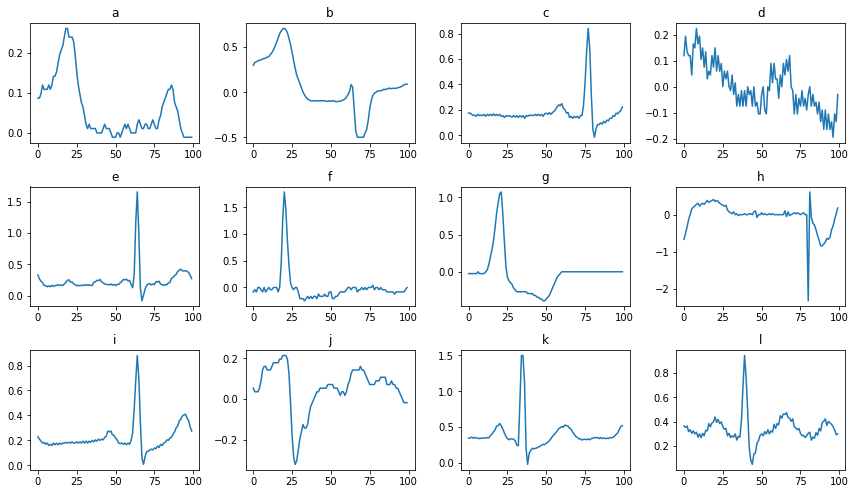

In [22]:
fig = plt.figure()
inx= 1
for value in centroid :
    ax = fig.add_subplot(4,4,inx)
    wave = findCentroid(value)
#    print("wave",wave)
    printCentroid(wave)
    inx=inx+1
plt.tight_layout()
plt.show()